In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import random
from torchvision import datasets, transforms
from utils import draw_bounding_box, visualize_img
from mnist_detection_dataset import MNISTDetectionDataset
from utils import batching_func, bce, save, load, yolo_visualize
from models import ConvLayer, Yolo
from torch.utils.tensorboard import SummaryWriter

FINAL_GRID_SIZE_I = 4
FINAL_GRID_SIZE_J = 13
N_CLASSES = 10
LAST_KERNEL_DIM = 30
N_ANCHORS = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bfunc = lambda l: batching_func(l, N_CLASSES, N_ANCHORS, FINAL_GRID_SIZE_I, FINAL_GRID_SIZE_J, LAST_KERNEL_DIM, device)

In [5]:
dataset1 = datasets.MNIST('MNIST', train=True, download=True)
dataset2 = datasets.MNIST('MNIST', train=False)
dataset1 = MNISTDetectionDataset(dataset1, ratio=2)
dataset2 = MNISTDetectionDataset(dataset2, ratio=2)
train_loader = torch.utils.data.DataLoader(dataset1, shuffle=True, num_workers=0, batch_size=64, collate_fn=bfunc)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=2, collate_fn=bfunc)

In [6]:
# out_channels, stride
conv_list = [
    [1, 1], #dummy begin
    [32, 2],
    [32, 1],
    [64, 2],
    [64, 1],
    [64, 1],
    [64, 1],
    [128, 2],
    [128, 1],
    [128, 1],
    [256, 2],
    [256, 1],
    # [512, 1],
    # [512, 1],
]

yolo = Yolo(conv_list, LAST_KERNEL_DIM, device, N_CLASSES, N_ANCHORS).to(device)
len(conv_list)-1

11

In [7]:
import numpy as np
model_parameters = filter(lambda p: p.requires_grad, yolo.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

1403262

In [5]:
writer = SummaryWriter('tb/mnist/modulelist2')

In [11]:
opt = torch.optim.Adam(yolo.parameters())

In [12]:
eps = 10
numsc = 1e-9
i_mbatch = 854
for ep in range(eps):
    for imgs, targets in train_loader:
        i_mbatch += 1
        class_ids, objectness, offsets, normalized_wh = targets
        preds_class_ids, preds_objectness, preds_offsets, preds_normalized_wh = yolo(imgs)
        
        # print(class_ids.shape, preds_class_ids.shape)
        indicator = class_ids.sum(dim=1).unsqueeze(1) > 0.5
        loss_c   = bce(class_ids, preds_class_ids, 1, indicator)
        loss_obj = bce(objectness, preds_objectness, 20)/20
        loss_off = bce(offsets, preds_offsets, 1, indicator)
        loss_wh  = (((normalized_wh-preds_normalized_wh)**2) *indicator).sum()/indicator.sum()
        
        loss = loss_c + loss_obj*20 + loss_off*2 + loss_wh*10
        opt.zero_grad()
        loss.backward()
        opt.step()

        if i_mbatch%1==0:
            print(ep, i_mbatch, loss_c.item(), loss_obj.item(), loss_off.item(), loss_wh.item())
        if i_mbatch % 50==0:
            save(yolo, 'mnist_yolo___', ep, i_mbatch)
            save(opt, 'mnist_opt___', ep, i_mbatch)

        step = ep*len(dataset1) + i_mbatch
        writer.add_scalar('loss/class', loss_c, step)
        writer.add_scalar('loss/object', loss_obj, step)
        writer.add_scalar('loss/offset', loss_off, step)
        writer.add_scalar('loss/bbox_wh', loss_wh, step)

407
0 909 0.4789382815361023 0.011956484988331795 1.0888631343841553 0.0036315142642706633
0 910 0.5195986032485962 0.011173766106367111 1.0964421033859253 0.002551533980295062
0 911 0.5928023457527161 0.0087507963180542 1.1074615716934204 0.0034839888103306293
0 912 0.3970303535461426 0.009515462443232536 1.0788936614990234 0.0030100548174232244
0 913 0.6077212691307068 0.008184383623301983 1.1023956537246704 0.0031010997481644154
0 914 0.6084336042404175 0.008417291566729546 1.0716867446899414 0.0033569152001291513
0 915 0.5473816394805908 0.01170110609382391 1.1221116781234741 0.0030874796211719513
0 916 0.5613164305686951 0.014325126074254513 1.1042349338531494 0.0026929418090730906
0 917 0.4648165702819824 0.009391727857291698 1.0726203918457031 0.002937780227512121
0 918 0.6581034064292908 0.010679168626666069 1.104225754737854 0.0033621746115386486
0 919 0.470928817987442 0.009827670641243458 1.0762258768081665 0.0021289594005793333
0 920 0.4795542061328888 0.009434179402887821 

RuntimeError: CUDA error: unspecified launch failure

In [76]:
ep = 0
i_mbatch = -1
save(yolo, 'mnist_yolo_', ep, i_mbatch)
save(opt, 'mnist_opt__', ep, i_mbatch)

In [ ]:
PATH = 'pretrained_models/mnist_yolo__'+str(ep)+'_'+str(i_mbatch)+'.th'
torch.save(yolo.state_dict(), PATH)

In [8]:
ep = 0
i_mbatch = 1100
load(yolo, 'mnist_yolo___', ep, i_mbatch)
# load(opt, 'mnist_opt___', ep, i_mbatch)

In [24]:
img, ann = dataset2[0]
import torch as th
img.shape

torch.Size([1, 50, 200])

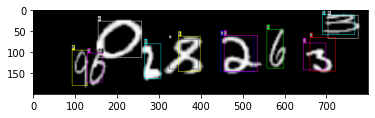

In [25]:
_ = yolo_visualize(yolo, img, final_grid_size_i=FINAL_GRID_SIZE_I, final_grid_size_j=FINAL_GRID_SIZE_J, scaled_img_height=200, scaled_img_width=800, batching_func=bfunc, thres=0.85)

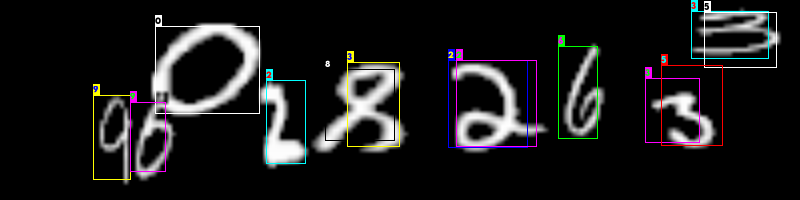

In [26]:
transforms.ToPILImage()(_[0])

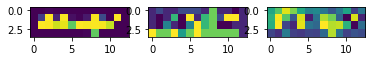

In [107]:
from utils import yolo_visualize_tensors
yolo_visualize_tensors(*_[1])

In [108]:
def IoU(self, bbox1, bbox2):
    x11, y11 = bbox1[0], bbox1[1]
    x12, y12 = x11+bbox1[2], y11+bbox1[3]
    x21, y21 = bbox2[0], bbox2[1]
    x22, y22 = x21+bbox2[2], y21+bbox2[3]
    xtop, ytop = max(x11, x21), max(y11, y21)
    xbot, ybot = min(x12, x22), min(y12, y22)

    if xtop<xbot and ytop<ybot:
        intersection = (xbot-xtop)*(ybot-ytop)
    else:
        intersection = 0
    area1 = bbox1[2]*bbox1[3]
    area2 = bbox2[2]*bbox2[3]
    union = area1 + area2 - intersection
    return intersection/union

def non_max_supression(confidence, annotation, thres=0.6):
    for i1, (con1, ann1) in enumerate(zip(confidence, annotation)):
        for i2, (con2, ann2) in enumerate(zip(confidence, annotation)):
            if i1 != i2:
                iou = IoU(ann1['bbox'], ann2['bbox'])
                if iou > thres:
                    irem = i1 if con1<con2 else i2
                    confidence[irem] = -1
                    annotation[irem] = {'bbox':(0, 0, 0, 0)}
    
    toret = 
    for i in range(len(confidence)):
        if confidence[i] = -1:
            
    return confidence, annotation
                


In [25]:
yolo.inference

ModuleAttributeError: 'Yolo' object has no attribute 'inference'

In [7]:
dummy_input = img.unsqueeze(0).to(device)
# func = lambda img: 
torch.onnx.export(yolo, (dummy_input, ), 'yolo.onnx', verbose=True,
                  input_names=['image'])

TypeError: Cannot handle this data type: (1, 1, 1), |u1

In [121]:
import onnxruntime as ort
ort_sess = ort.InferenceSession('yolo.onnx')
outputs = ort_sess.run(None, {'image': img.unsqueeze(0).numpy(),})
outputs

[array([[[[1.19262248e-01, 9.99872983e-02, 4.44886386e-02,
           1.33456558e-01, 1.17889941e-01, 8.96596909e-03,
           7.59533048e-03, 5.45971394e-02, 6.20322824e-02,
           6.68386221e-02, 1.43705100e-01, 3.00513238e-01,
           1.02644950e-01],
          [2.83335745e-02, 2.40114331e-03, 5.43594360e-05,
           3.73598933e-03, 6.14523888e-05, 1.04376674e-03,
           4.67509031e-04, 1.66893005e-05, 2.44647264e-04,
           2.86728144e-04, 8.24737549e-03, 3.21552157e-03,
           2.66913474e-02],
          [2.20823288e-03, 8.68707895e-04, 5.33133745e-03,
           8.54781270e-03, 3.72916460e-04, 4.52277362e-02,
           3.84260893e-01, 7.11083412e-05, 7.31170177e-04,
           1.02430582e-04, 2.96831131e-05, 1.17246211e-02,
           8.37495923e-02],
          [4.05633152e-02, 3.77890468e-03, 8.93868804e-02,
           4.60069180e-02, 3.52960229e-02, 1.03056163e-01,
           7.33335912e-02, 3.33748460e-02, 9.72170234e-02,
           3.16175818e-02, 2.51